<a href="https://colab.research.google.com/github/yuji-sgs/web-optimization/blob/main/chapter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-916-8.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『ウェブ最適化ではじめる機械学習』（飯塚 修平　著）](https://www.oreilly.co.jp/books/9784873119168/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

# 3章: 組合せのあるテスト: 要素に分解して考える

In [2]:
# 必要なモジュールの読み込み
import numpy as np
from matplotlib import pyplot as plt
import pymc as pm

plt.style.use('grayscale')
plt.style.use('seaborn-whitegrid')
np.random.seed(0)

<ipython-input-2-89b4c6d4cdb1>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## チャーリーのレポート

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


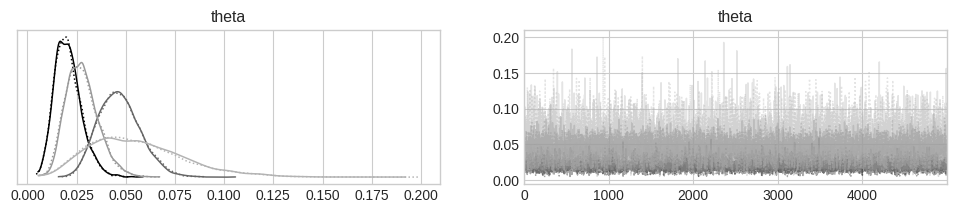

In [ ]:
# クリック率  𝜃  のサンプルの軌跡
n = [434, 382, 394, 88]
clicks = [8, 17, 10, 4]
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=len(n))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace = pm.sample(5000, chains=2)
  pm.plot_trace(trace, compact=True)

In [ ]:
pm.summary(trace, hdi_prob=0.95)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.021,0.007,0.008,0.035,0.0,0.0,15921.0,7185.0,1.0
theta[1],0.047,0.011,0.028,0.068,0.0,0.0,15990.0,8027.0,1.0
theta[2],0.028,0.008,0.013,0.044,0.0,0.0,15637.0,7541.0,1.0
theta[3],0.055,0.024,0.015,0.104,0.0,0.0,12104.0,6550.0,1.0


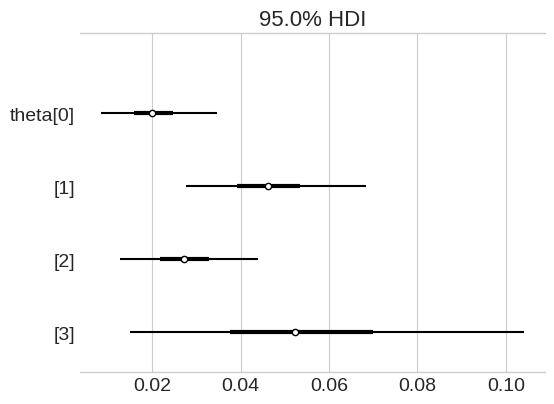

In [ ]:
# 確率変数  𝜃  の事後分布の95% HDIの比較
with model:
  pm.plot_forest(trace, combined=True, hdi_prob=0.95)

In [ ]:
# A案とB案のクリック率の差が正となる割合
theta_A = trace.posterior['theta'].sel(theta_dim_0=0).values.flatten()
theta_B = trace.posterior['theta'].sel(theta_dim_0=1).values.flatten()
print((theta_B - theta_A > 0).mean())

0.9814


In [ ]:
# A案とD案のクリック率の差が正となる割合
theta_A = trace.posterior['theta'].sel(theta_dim_0=0).values.flatten()
theta_D = trace.posterior['theta'].sel(theta_dim_0=3).values.flatten()
print((theta_D - theta_A > 0).mean())

0.9457


**D案が一番クリック率は高かったが、それをサポートする表示回数が少ないため、判断基準である95%には満たなかった。**

## 効果に着目したモデリング

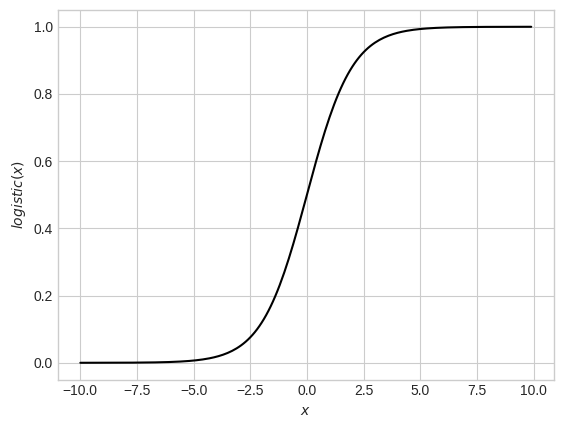

In [3]:
# ロジスティック関数
xs = np.arange(-10, 10, 0.1)
plt.plot(xs, 1 / (1 + np.exp(-xs)))
plt.xlabel(r'$x$')
plt.ylabel(r'$logistic(x)$')
plt.show()

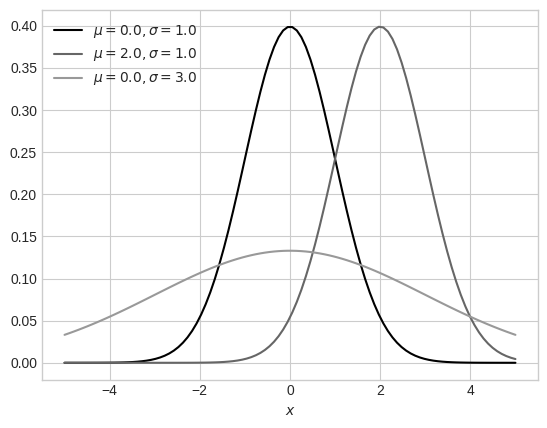

In [4]:
# さまざまな正規分布の例
from scipy import stats
x = np.linspace(-5, 5, 100)
params = [(0, 1), (2, 1), (0, 3)]
for mu, sigma in params:
  plt.plot(x, stats.norm.pdf(x, mu, sigma),
      label=r'$\mu=%.1f, \sigma=%.1f$' % (mu, sigma))
plt.legend()
plt.xlabel(r'$x$')
plt.show()